# Climate change and the Salt Lake Olympics

## Introduction

Salt Lake City was selected in late November by International Olympic Committee leaders as the preferred host for the 2034 Winter Games. Utah is known to have the "Greatest Snow on Earth", but with recent concerns over climate change, will this still be true 10 years from now?


The aim of this project is to use statistical methods to understand and visualize how snowfall in Utah has changed over the last 30 years, and to predict how this might affect the potential 2034 Salt Lake Olympics.

## Project Goals

Can we use past and current winter snowfall trends to predict what the snowfall will be in 2034?

## Learning objective

We want to be able to clearly demonstrate snowfall through graphs and statistical findings how snowfall over time has affected different Utah cities (Salt Lake City, Provo, and Ogden), using regression models via python.



## Data Acquisition

We got our data from Oikolab. They get their data from various sources, such as NOAA, GEFS, CHIRPS, and ERA5. The data came in a csv file, with a variety of variables to choose from, all of which we explored in our autoregression file, in which we decided which variables to focus on in our correlation matrix. 


## Simple Linear Regression

The purpose of this regression is to analyze trends in snowfall over the last 20 years.

In [2]:
# imports 

import pandas as pd

ogden = "Ogden_Data.csv"
provo = "Provo_Data.csv"
slc = "SLC_All_Param.csv"
ogden_df = pd.read_csv(ogden)
provo_df = pd.read_csv(provo)
slc_df = pd.read_csv(slc)

In [3]:
# Parse datetime and split coordinates
ogden_df['datetime (UTC)'] = pd.to_datetime(ogden_df['datetime (UTC)'])
ogden_df[['latitude', 'longitude']] = ogden_df['coordinates (lat,lon)'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)

provo_df['datetime (UTC)'] = pd.to_datetime(provo_df['datetime (UTC)'])
provo_df[['latitude', 'longitude']] = provo_df['coordinates (lat,lon)'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)

slc_df['datetime (UTC)'] = pd.to_datetime(slc_df['datetime (UTC)'])
slc_df[['latitude', 'longitude']] = slc_df['coordinates (lat,lon)'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)

# Encode categorical variables
ogden_df_encoded = pd.get_dummies(ogden_df, columns=['model (name)'])
provo_df_encoded = pd.get_dummies(provo_df, columns=['model (name)'])
slc_df_encoded = pd.get_dummies(slc_df, columns=['model (name)'])

# break down the UTC t from datetime
ogden_df_encoded['hour'] = ogden_df_encoded['datetime (UTC)'].dt.hour
ogden_df_encoded['day'] = ogden_df_encoded['datetime (UTC)'].dt.day
ogden_df_encoded['month'] = ogden_df_encoded['datetime (UTC)'].dt.month
ogden_df_encoded['year'] = ogden_df_encoded['datetime (UTC)'].dt.year

provo_df_encoded['hour'] = provo_df_encoded['datetime (UTC)'].dt.hour
provo_df_encoded['day'] = provo_df_encoded['datetime (UTC)'].dt.day
provo_df_encoded['month'] = provo_df_encoded['datetime (UTC)'].dt.month
provo_df_encoded['year'] = provo_df_encoded['datetime (UTC)'].dt.year

slc_df_encoded['hour'] = slc_df_encoded['datetime (UTC)'].dt.hour
slc_df_encoded['day'] = slc_df_encoded['datetime (UTC)'].dt.day
slc_df_encoded['month'] = slc_df_encoded['datetime (UTC)'].dt.month
slc_df_encoded['year'] = slc_df_encoded['datetime (UTC)'].dt.year

# Drop the original datetime and coordinates columns
ogden_df_encoded.drop(['datetime (UTC)', 'coordinates (lat,lon)'], axis=1, inplace=True)
provo_df_encoded.drop(['datetime (UTC)', 'coordinates (lat,lon)'], axis=1, inplace=True)
slc_df_encoded.drop(['datetime (UTC)', 'coordinates (lat,lon)'], axis=1, inplace=True)

In [4]:
# Select features and target variable
features = ['temperature (degC)', 'relative_humidity (0-1)', 'total_precipitation (mm of water equivalent)', 'total_cloud_cover (0-1)']
target_variable = 'snowfall (mm of water equivalent)'

ogden_data = ogden_df_encoded[['month', 'year', target_variable] + features].copy()
provo_data = provo_df_encoded[['month', 'year', target_variable] + features].copy()
slc_data = slc_df_encoded[['month', 'hour', 'year', target_variable] + features].copy()

In [5]:
# Chose the month based on the month column, for SLC specified hour
ogden_filtered_data = ogden_data[ogden_data['month'] == 2]
provo_filtered_data = provo_data[provo_data['month'] == 2]
slc_filtered_data = slc_data[(slc_data['hour'] == 10) & (slc_data['month'] == 2) & (slc_data['year'] >= 2005)]

# Found the mean for each year's data
slc_yearly_mean = slc_filtered_data.groupby('year').mean()

slc_yearly_mean = slc_yearly_mean.reset_index()

In [6]:
import statsmodels.api as sm

# Make the x variable the year and the y variable the snowfall and finding OLS
ogden_x = ogden_filtered_data['year']
ogden_y = ogden_filtered_data['snowfall (mm of water equivalent)']
ogden_result = sm.OLS(ogden_y, ogden_x).fit()

provo_x = provo_filtered_data['year']
provo_y = provo_filtered_data['snowfall (mm of water equivalent)']
provo_result = sm.OLS(provo_y, provo_x).fit()

slc_x = slc_yearly_mean['year']
slc_y = slc_yearly_mean['snowfall (mm of water equivalent)']
slc_result = sm.OLS(slc_y, slc_x).fit()

print("Ogden OLS")
print(ogden_result.summary())
print("Provo OLS")
print(provo_result.summary())
print("Salt Lake City OLS")
print(slc_result.summary())

Ogden OLS
                                        OLS Regression Results                                        
Dep. Variable:     snowfall (mm of water equivalent)   R-squared (uncentered):                   0.843
Model:                                           OLS   Adj. R-squared (uncentered):              0.835
Method:                                Least Squares   F-statistic:                              102.4
Date:                               Fri, 19 Apr 2024   Prob (F-statistic):                    4.35e-09
Time:                                       09:22:24   Log-Likelihood:                          47.021
No. Observations:                                 20   AIC:                                     -92.04
Df Residuals:                                     19   BIC:                                     -91.05
Df Model:                                          1                                                  
Covariance Type:                           nonrobust           

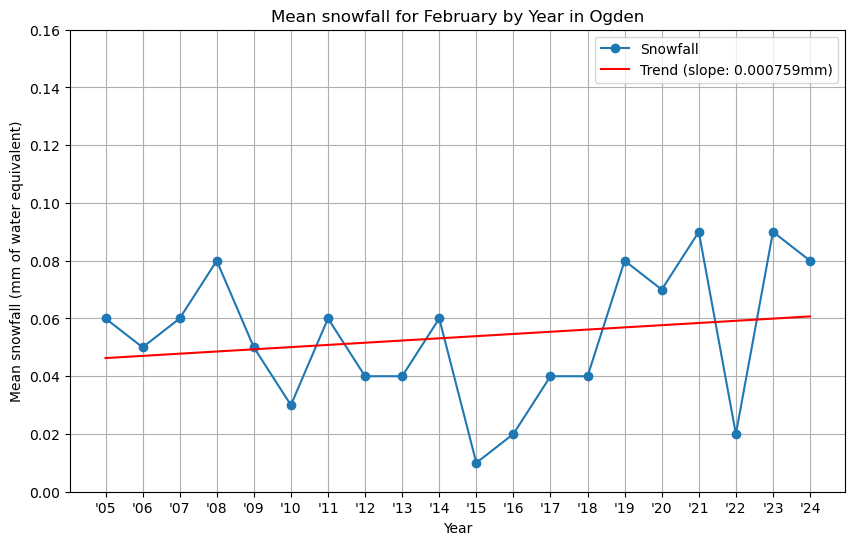

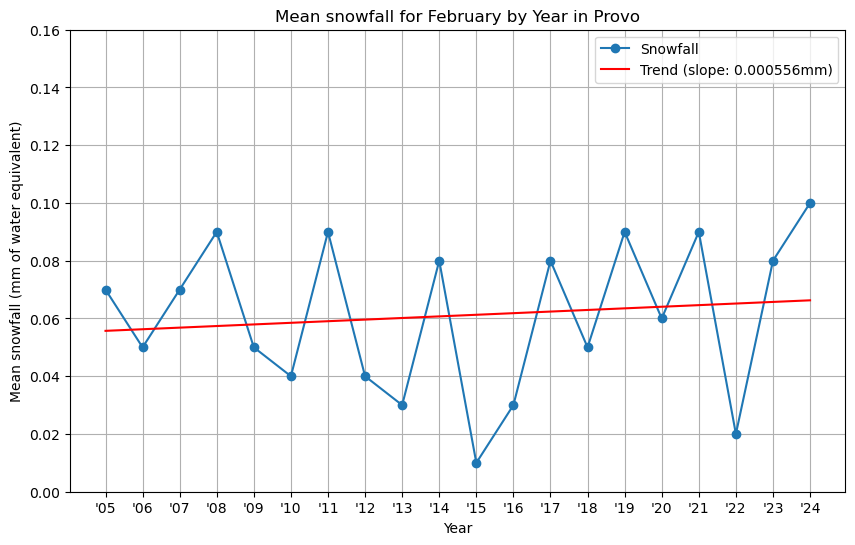

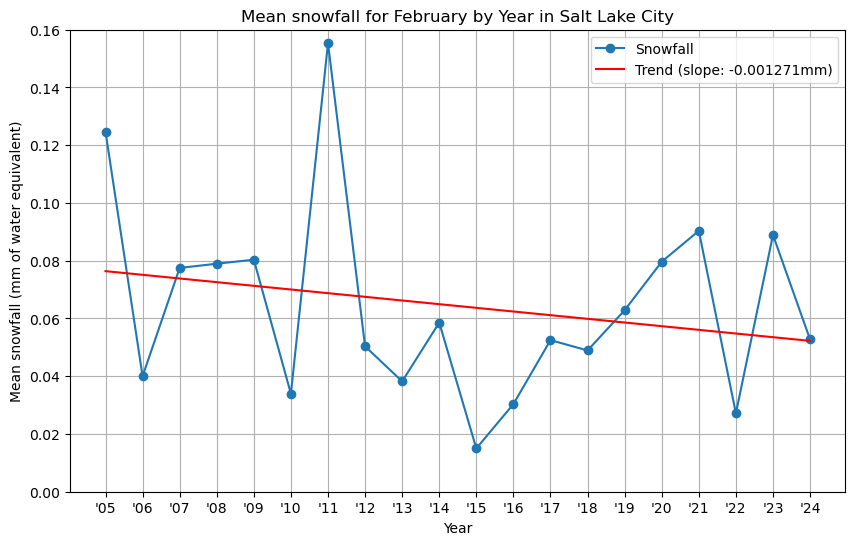

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# regression line
def regression_line(x, y):
    m, b = np.polyfit(x, y, 1)
    return m * x + b, m

def plot_regression(x, y, city):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', label='Snowfall')

    regression, slope = regression_line(x, y)
    plt.plot(x, regression, color='red', label=f'Trend (slope: {slope:8f}mm)')

    # ticks of 1 year
    plt.xticks(np.arange(min(x), max(x)+1, 1))

    # make tick labels less awful
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"'{int(x) % 100:02d}"))
    
    # consistent y-axis
    plt.ylim(0, .16)

    plt.title(f'Mean snowfall for February by Year in {city}')
    plt.xlabel('Year')
    plt.ylabel('Mean snowfall (mm of water equivalent)')
    plt.grid(True)
    plt.legend()
    plt.show()

# output

plot_regression(ogden_x, ogden_y, 'Ogden')

plot_regression(provo_x, provo_y, 'Provo')

plot_regression(slc_x, slc_y, 'Salt Lake City')


These graphs show the trends in snowfall over the last ~20 years. The slope of the regression lines indicates the overall change.

# Auto Regression

This is a model for predicting snowfall in 10 years.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
file_path = 'SLC_all_param.csv'
df = pd.read_csv(file_path)


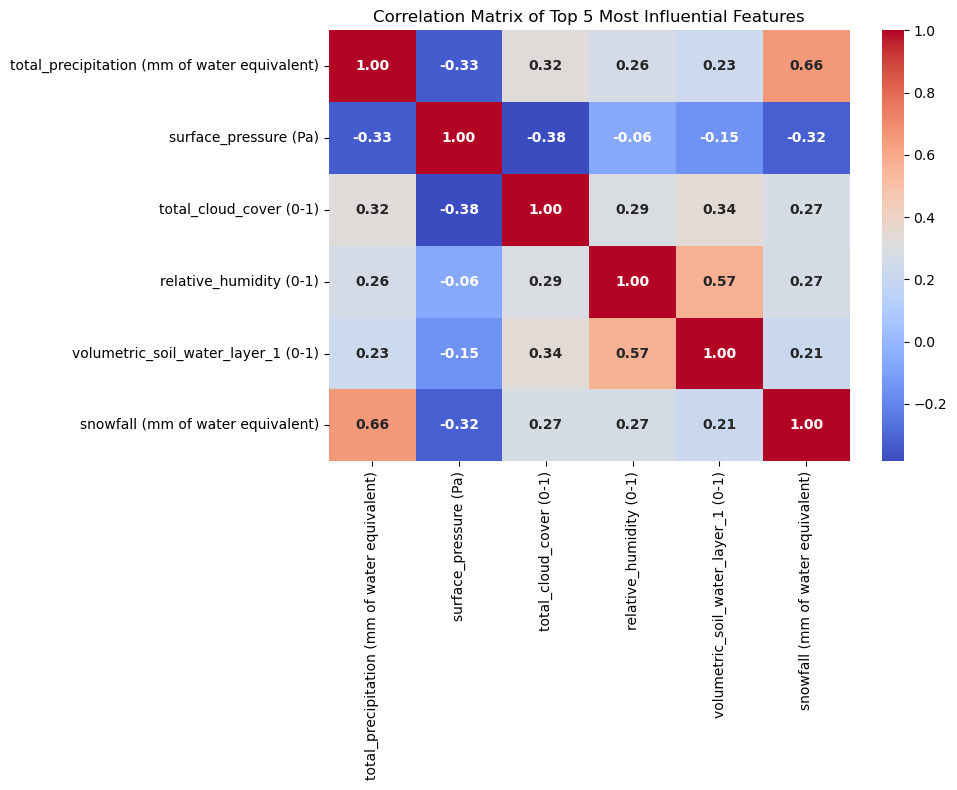

In [9]:
#Preprocessing for all features

# Parse datetime and split coordinates
df['datetime (UTC)'] = pd.to_datetime(df['datetime (UTC)'])
df[['latitude', 'longitude']] = df['coordinates (lat,lon)'].str.extract(r'\(([^,]+), ([^)]+)\)').astype(float)

# Drop columns with 50% or more null values
df = df.dropna(thresh=len(df) * 0.7, axis=1)

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['model (name)'])

# break down the UTC t from datetime
df_encoded['hour'] = df_encoded['datetime (UTC)'].dt.hour
df_encoded['day'] = df_encoded['datetime (UTC)'].dt.day
df_encoded['month'] = df_encoded['datetime (UTC)'].dt.month
df_encoded['year'] = df_encoded['datetime (UTC)'].dt.year

# Drop the original datetime and coordinates columns
df_encoded.drop(['datetime (UTC)', 'coordinates (lat,lon)'], axis=1, inplace=True)

# Scaling numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded.select_dtypes(include=['float64', 'int64']))  # Scale only numerical features
df_scaled = pd.DataFrame(scaled_features, columns=df_encoded.select_dtypes(include=['float64', 'int64']).columns)
df_encoded[df_scaled.columns] = df_scaled

# Calculate correlation with target variable
correlation_with_target = df_encoded.corr()['snowfall (mm of water equivalent)'].abs()

# Select top 5 most influential features (excluding the target variable)
top_5_features = correlation_with_target.sort_values(ascending=False).index[1:6]


# Create correlation matrix using only the top 5 features and the target variable
correlation_matrix = df_encoded[top_5_features].join(df_encoded['snowfall (mm of water equivalent)']).corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize":10, "weight": "bold"})
plt.title("Correlation Matrix of Top 5 Most Influential Features")
plt.tight_layout()
plt.show()


In [10]:
top_10_features = correlation_with_target.sort_values(ascending=False).index[1:11]

# Print top 10 features and their correlation values
print("Top 10 features and their correlation with Snowfall:")
for feature in top_10_features:
    correlation_value = correlation_with_target[feature]
    print(f"{feature}: {correlation_value:.2f}")

Top 10 features and their correlation with Snowfall:
total_precipitation (mm of water equivalent): 0.66
surface_pressure (Pa): 0.32
total_cloud_cover (0-1): 0.27
relative_humidity (0-1): 0.27
volumetric_soil_water_layer_1 (0-1): 0.21
heating_degreeday (degC-Day): 0.20
soil_temperature_level_2 (degC): 0.20
snow_depth (mm of water equivalent): 0.20
soil_temperature_level_1 (degC): 0.20
temperature (degC): 0.20


In [11]:
# reload the CSV file into a DataFrame/ prevents any alterations that may of occured earlier in the code.
df = pd.read_csv(file_path)

# Preproccessing of data

# Parse datetime and split coordinates
df['datetime (UTC)'] = pd.to_datetime(df['datetime (UTC)'])

# Select features and target variable
features = ['temperature (degC)', 'relative_humidity (0-1)', 'total_precipitation (mm of water equivalent)', 'total_cloud_cover (0-1)']
target_variable = 'snowfall (mm of water equivalent)'

data = df[['datetime (UTC)', target_variable] + features].copy()

data['hour'] = data['datetime (UTC)'].dt.hour
data['day'] = data['datetime (UTC)'].dt.day
data['month'] = data['datetime (UTC)'].dt.month
data['year'] = data['datetime (UTC)'].dt.year

data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data.set_index('date', inplace=True)

# Drop the original datetime and coordinates columns
data.drop(['datetime (UTC)'], axis=1, inplace=True)

In [12]:
filtered_data = data[(data['hour'] == 10) & (data['month'] == 2)]

# Create a DataFrame from the filtered data
df = pd.DataFrame(filtered_data.copy())
df2 = df.copy()

snowfall_mean = df['snowfall (mm of water equivalent)'].mean()

print("Mean snowfall (mm of water equivalent) for all Februarys (1994-2024):", snowfall_mean)

# Filter the data for February (month = 2)
february_data = df2[df2['month'] == 2]

# Group by year, calculate the mean
yearly_mean = february_data.groupby('year').mean()

# Reset index to make 'year' as a column
yearly_mean = yearly_mean.reset_index()

Mean snowfall (mm of water equivalent) for all Februarys (1994-2024): 0.06596698113207547


In [13]:
# Assuming filtered_data contains the DataFrame you provided earlier

# Define the features and target variable
features = ['temperature (degC)', 'relative_humidity (0-1)', 'total_precipitation (mm of water equivalent)', 'total_cloud_cover (0-1)', 'date']
target_variable = 'snowfall (mm of water equivalent)'

# Recreate the index with a specific frequency (assuming daily frequency)
df.index = pd.date_range(start=df.index.min(), periods=len(df), freq='D')

# Fit autoregression model
model = AutoReg(df[target_variable], lags=1)  # Assuming lag order is 1
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start='2034-02-10', end='2034-02-10', dynamic=False)

# Define the date for which you want to make the prediction
prediction_date = '2034-02-10'

# Predict snowfall for the specified date
prediction = model_fit.predict(start=prediction_date, end=prediction_date)

print("Predicted snowfall on February 10, 2034:", prediction.values[0])

Predicted snowfall on February 10, 2034: 0.0660448642266824


In [14]:
# Calculate summary statistics from historical data
historical_mean = df['snowfall (mm of water equivalent)'].mean()
historical_std = df['snowfall (mm of water equivalent)'].std()

# Compare with predicted snowfall
predicted_snowfall = prediction.values[0]  # Your predicted snowfall value
significance_level = 0.95  # For example, use 95% confidence interval

# Calculate the upper and lower bounds of significance
upper_bound = historical_mean + significance_level * historical_std
lower_bound = historical_mean - significance_level * historical_std

print("Historic Mean:")
print(historical_mean)

print("Upper:")
print(upper_bound)
print("Lower:")
print(lower_bound)
print("Predicted:")
print(predicted_snowfall)


Historic Mean:
0.06596698113207547
Upper:
0.25864005114304967
Lower:
-0.1267060888788987
Predicted:
0.0660448642266824


In [15]:
# Find historical maximum and minimum snowfall values
historical_max = df2['snowfall (mm of water equivalent)'].max()
historical_min = df2['snowfall (mm of water equivalent)'].min()

# Find dates corresponding to the maximum and minimum snowfall values
date_max_values = df2[df2['snowfall (mm of water equivalent)'] == historical_max][['day', 'month', 'year']].iloc[0]
date_min_values = df2[df2['snowfall (mm of water equivalent)'] == historical_min][['day', 'month','year' ]].iloc[0]

# Convert date values to the desired format
date_max_str = '/'.join(str(x) for x in date_max_values)
date_min_str = '/'.join(str(x) for x in date_min_values)

# Print the maximum and minimum values along with their corresponding dates
print("Historical Maximum Snowfall:", historical_max, "mm")
print("Date of Maximum Snowfall:", date_max_str)
print("Historical Minimum Snowfall:", historical_min, "mm")
print("Date of Minimum Snowfall:", date_min_str)

Historical Maximum Snowfall: 2.88 mm
Date of Maximum Snowfall: 2/2/2003
Historical Minimum Snowfall: 0.0 mm
Date of Minimum Snowfall: 1/2/1995


In [16]:
# Define the target variable
target_variable = 'snowfall (mm of water equivalent)'

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(df) * split_ratio)
train, test = df.iloc[:split_index], df.iloc[split_index:]

# Fit the model on the training data
model = AutoReg(train[target_variable], lags=5)
model_fit = model.fit()

# Predict on the test data
start = len(train)
end = len(df) - 1
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Calculate error metrics
mse = mean_squared_error(test[target_variable], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test[target_variable], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

MSE: 0.03011904771802122
RMSE: 0.17354840165792718
MAE: 0.09120944960889406


# Conclusion

### Ethical Considerations



### Interpretation of findings



### Limitations


